In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import matplotlib.pyplot as plt

In [2]:
class RBM(nn.Module):
    def __init__(self, n_vis=784, n_hid=500, k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.k = k
    
    def sample_from(self, p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self, v):
        p_h = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from(p_h)
        return p_h, sample_h
    
    def h_to_v(self, h):
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from(p_v)
        return p_v, sample_v
        
    # Run k epochs of Gibbs sampling
    def forward(self, v):
        _, h_ = self.v_to_h(v)
        for _ in range(self.k):
            _, v_ = self.h_to_v(h_)
            _, h_ = self.v_to_h(v_)
        return v_
    
    def free_energy(self, v):
        term1 = v.mv(self.v_bias)
        term2 = F.linear(v, self.W, self.h_bias).exp().add(1).log().sum(1)
        return (-term1 - term2).mean()

In [3]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size)

In [4]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(), 0.1)

In [5]:
n_epochs = 8
for epoch in range(n_epochs):
    losses = []
    
    for _, (data, target) in enumerate(train_loader):
        v = Variable(data.view(-1, 784)) # Floats in [0, 1] 
        v_data = v.bernoulli() # Input sampled from Bernoulli
        v_model = rbm(v_data) # Output after k epochs of Gibbs sampling
        
        # Loss function from http://deeplearning.net/tutorial/rbm.html
        loss = rbm.free_energy(v_data) - rbm.free_energy(v_model)
        
        losses.append(loss.data[0])
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    print "Epoch {}, loss = {}".format(epoch, np.mean(losses))

Epoch 0, loss = -8.41047019389
Epoch 1, loss = -6.62523177743
Epoch 2, loss = -4.56233104714
Epoch 3, loss = -3.10552945981
Epoch 4, loss = -2.23133837084
Epoch 5, loss = -1.56748064444
Epoch 6, loss = -1.08463666383
Epoch 7, loss = -0.736507293766


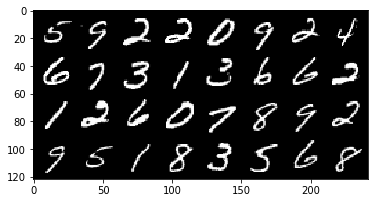

In [6]:
def show_and_save(file_name, img):
    np_img = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(np_img)
    plt.imsave(f, np_img)
    plt.show()
    
show_and_save("real", make_grid(v.view(32,1,28,28).data))

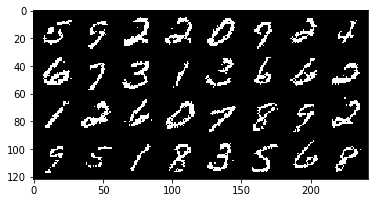

In [7]:
show_and_save("generated", make_grid(v_model.view(32,1,28,28).data))